In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("manipulated_data.csv")

# Convert the 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

data.head()


,date,humidity,solar_irradiance,temperature,energy_production
0,2022-01-01,62.483571,519.584526,19.584632,171965.0
1,2022-01-02,59.653418,407.333812,16.585660,171026.0
2,2022-01-03,63.927819,551.165919,19.889962,206393.0
3,2022-01-04,68.648958,345.248763,18.223795,226307.0
4,2022-01-05,60.207166,623.584561,19.291879,205385.0


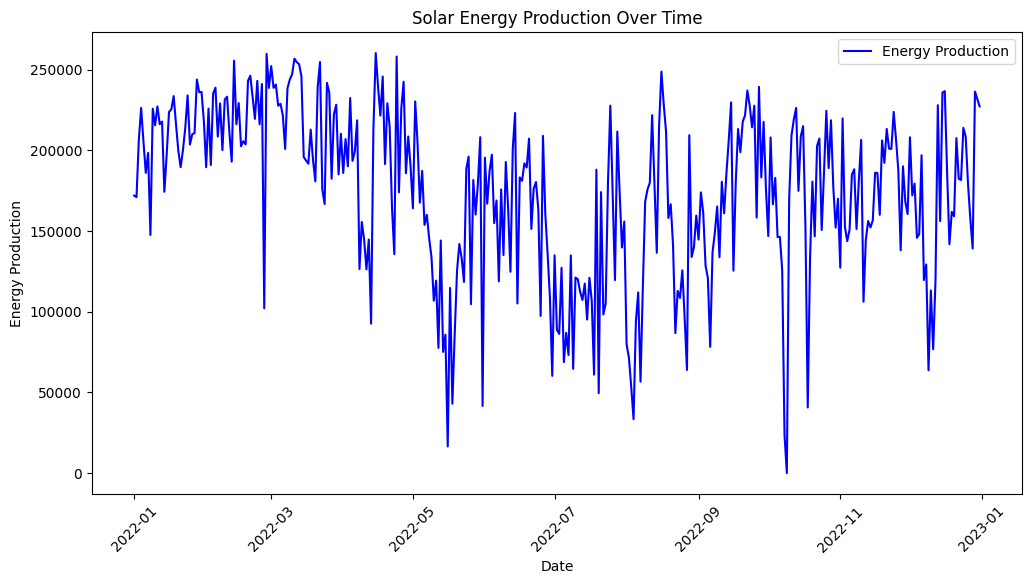

In [22]:
# Plot solar energy production over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['energy_production'], label='Energy Production', color='blue')
plt.title('Solar Energy Production Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Apply a moving average with a window size of 7 days
# data['energy_production'] = data['energy_production'].rolling(window=7, min_periods=1).mean()
data['energy_production'] = data['energy_production'].ewm(span=7, adjust=False).mean()

# Plot the smoothed energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Smoothed Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Smoothed Solar Energy Production Over Time')
plt.legend()
plt.show()

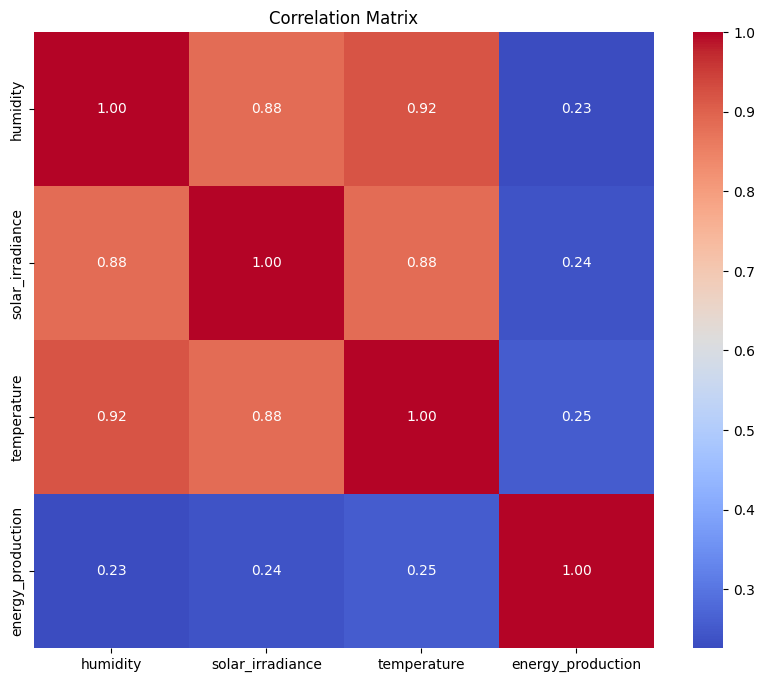

In [23]:
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

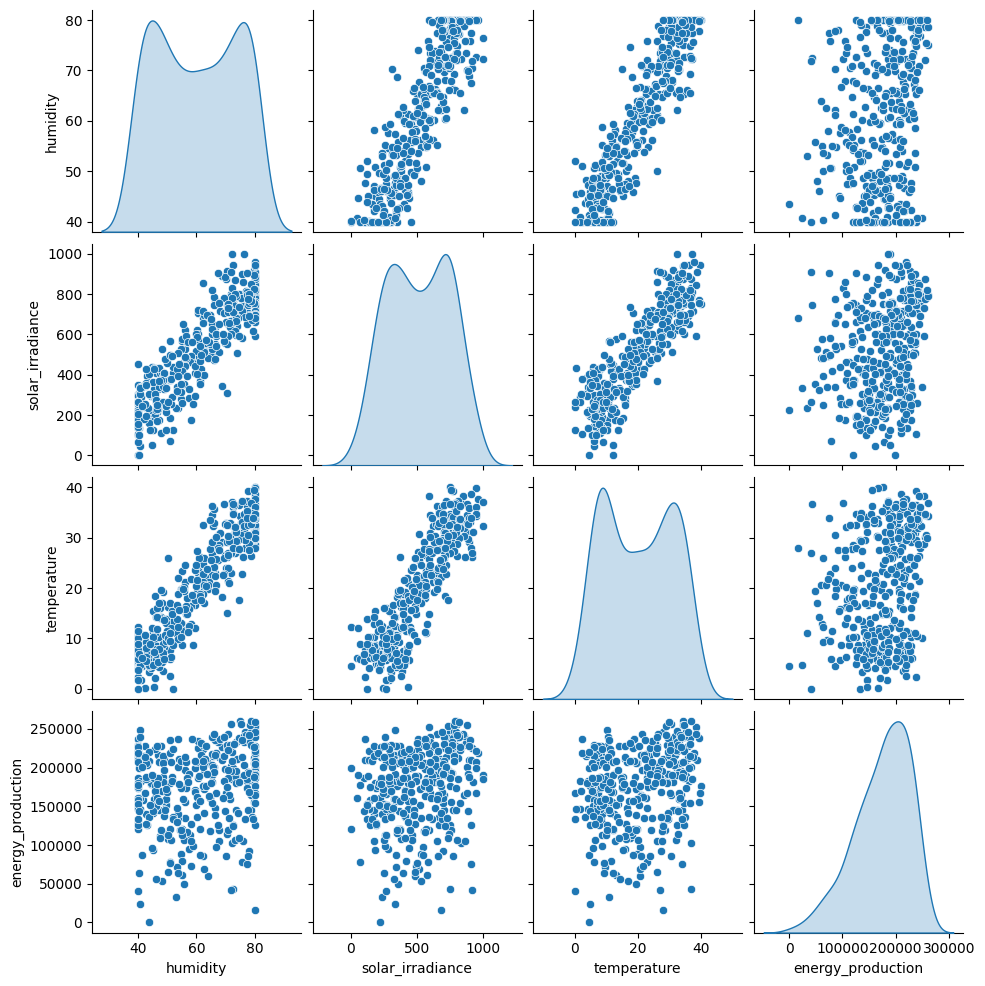

In [24]:
# Plot pairwise relationships between features and target variable
sns.pairplot(data, diag_kind='kde')
plt.show()

In [25]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Split the data into features (X) and target (y)
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

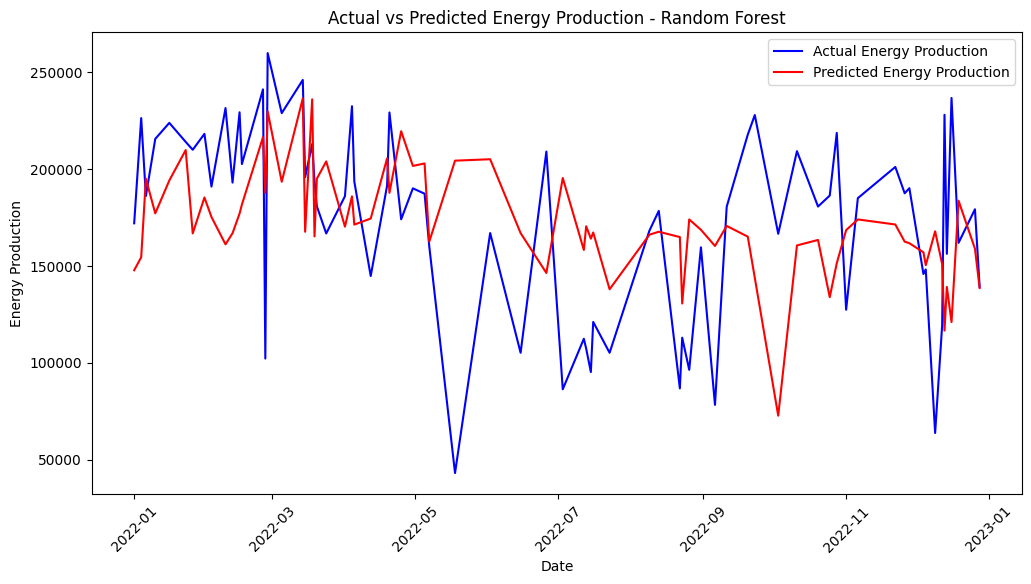

In [26]:
# Merge the test predictions with their corresponding dates
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date'] = data.loc[X_test.index, 'date']  # Match dates with the test set index

# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - Random Forest')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()


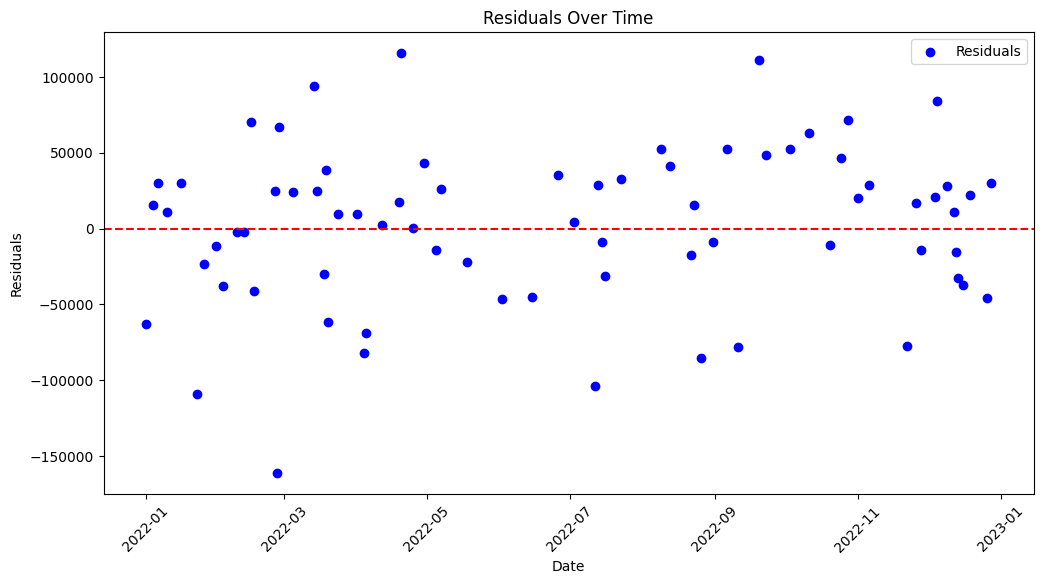

In [27]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(test_results['date'], residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.xticks(rotation=45)
plt.show()


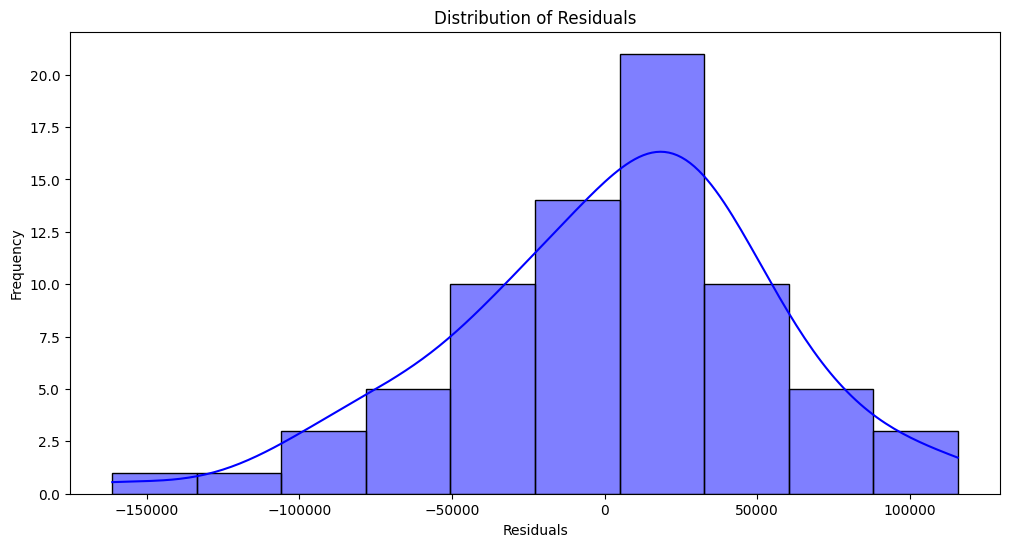

In [28]:
# Plot distribution of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [29]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')


MAE: 40625.976986301364
RMSE: 51640.67015377859
R2 Score: -0.12546177042927575


In [30]:
# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

Accuracy: -12.55%
